### ResNet50 Model

References:

https://towardsdatascience.com/understand-and-implement-resnet-50-with-tensorflow-2-0-1190b9b52691

https://github.com/suvoooo/Learn-TensorFlow/blob/master/resnet/Implement_Resnet_TensorFlow.ipynb

https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/

Batch Size: 256

Number of Dropout Layers: 2

Number of BatchNorm Layers: 2

Dropout Probability: 0.2

Data Augmentation: true

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import  Rectangle
import tensorflow as tf

import os
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPool2D,MaxPooling2D, Flatten,BatchNormalization, Dropout,ZeroPadding2D, AveragePooling2D, Add, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import activations
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

from tensorflow.keras.datasets import cifar10
from keras.utils import to_categorical

import time
import pickle

Using TensorFlow backend.


In [2]:
## taken from class resource posted on Campuswire
## https://medium.com/@ombelinelag/cutout-regularization-for-cnns-62670d86bc33
def apply_mask(image, size=12, n_squares=1):
    h, w, channels = image.shape
    new_image = np.copy(image)
    for _ in range(n_squares):
        y = np.random.randint(h)
        x = np.random.randint(w)
        y1 = np.clip(y - size // 2, 0, h)
        y2 = np.clip(y + size // 2, 0, h)
        x1 = np.clip(x - size // 2, 0, w)
        x2 = np.clip(x + size // 2, 0, w)
        new_image[y1:y2,x1:x2,:] = 0
    return new_image

In [3]:
#Define the Model
#Removing all regularizers

def res_identity(x, filters, num_batchnorm = 0, num_dropout=0, dropout_prob = 0):
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

    x_skip = x # this will be used for addition with the residual block 
    f1, f2 = filters
    bn = num_batchnorm
    drp = num_dropout

    #first block 
    x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
    if bn>0:
        x = BatchNormalization()(x)
        bn-=1
    x = Activation(activations.relu)(x)
    if drp>0:
        x = Dropout(dropout_prob)(x)
        drp-=1

    #second block # bottleneck (but size kept same with padding)
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    if bn>0:
        x = BatchNormalization()(x)
        bn-=1
    x = Activation(activations.relu)(x)
    if drp>0:
        x = Dropout(dropout_prob)(x)
        drp-=1

    # third block activation used after adding the input
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
    if bn>0:
        x = BatchNormalization()(x)
        bn-=1
    x = Activation(activations.relu)(x)
    if drp>0:
        x = Dropout(dropout_prob)(x)
        drp-=1

    # add the input 
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)


    return x

def res_conv(x, s, filters, num_batchnorm = 0, num_dropout=0, dropout_prob = 0):
    x_skip = x
    f1, f2 = filters
    bn = num_batchnorm
    drp = num_dropout

    # first block
    x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid')(x)
    # when s = 2 then it is like downsizing the feature map
    if bn>0:
        x = BatchNormalization()(x)
        bn-=1
    x = Activation(activations.relu)(x)
    if drp>0:
        x = Dropout(dropout_prob)(x)
        drp-=1

    # second block
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    if bn>0:
        x = BatchNormalization()(x)
        bn-=1
    x = Activation(activations.relu)(x)
    if drp>0:
        x = Dropout(dropout_prob)(x)
        drp-=1

    #third block
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
    if bn>0:
        x = BatchNormalization()(x)
        bn-=1

    # shortcut 
    x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid')(x_skip)
    x_skip = BatchNormalization()(x_skip)

    # add 
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)

    return x

def resnet50(num_batchnorm = 0, bn_pooling = False, dropout_prob=0, num_dropout_conv = 0, num_dropout_id = 0, num_dropout=0):

    input_im = Input(shape=(32, 32, 3)) # cifar 10 images size
    x = ZeroPadding2D(padding=(3, 3))(input_im)
    bn = num_batchnorm
    drp = num_dropout

    # 1st stage
    # here we perform maxpooling, see the figure above

    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
    if bn_pooling:
        x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    if drp>0:
        x = Dropout(dropout_prob)(x)
        drp-=1

    #2nd stage 
    # frm here on only conv block and identity block, no pooling

    x = res_conv(x, s=1, filters=(64, 256),num_batchnorm=bn, num_dropout = num_dropout_conv, dropout_prob = dropout_prob)
    x = res_identity(x, filters=(64, 256),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)
    x = res_identity(x, filters=(64, 256),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)

    # 3rd stage

    x = res_conv(x, s=2, filters=(128, 512),num_batchnorm=bn, num_dropout = num_dropout_conv, dropout_prob = dropout_prob)
    x = res_identity(x, filters=(128, 512),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)
    x = res_identity(x, filters=(128, 512),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)
    x = res_identity(x, filters=(128, 512),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)

    # 4th stage

    x = res_conv(x, s=2, filters=(256, 1024),num_batchnorm=bn, num_dropout = num_dropout_conv, dropout_prob = dropout_prob)
    x = res_identity(x, filters=(256, 1024),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)
    x = res_identity(x, filters=(256, 1024),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)
    x = res_identity(x, filters=(256, 1024),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)
    x = res_identity(x, filters=(256, 1024),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)
    x = res_identity(x, filters=(256, 1024),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)

    # 5th stage

    x = res_conv(x, s=2, filters=(512, 2048),num_batchnorm=bn, num_dropout = num_dropout_conv, dropout_prob = dropout_prob)
    x = res_identity(x, filters=(512, 2048),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)
    x = res_identity(x, filters=(512, 2048),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)

    # ends with average pooling and dense connection

    x = AveragePooling2D((2, 2), padding='same')(x)

    x = Flatten()(x)
    if drp>0:
        x = Dropout(dropout_prob)(x)
        drp-=1
    x = Dense(10, activation='softmax')(x) #multi-class

    # define the model 

    model = Model(inputs=input_im, outputs=x, name='Resnet50')

    return model

In [4]:
#to measure Time to Accuracy
#https://keras.io/guides/writing_your_own_callbacks/

class timeToAccuracy(keras.callbacks.Callback):
    def __init__(self, startTime, epoch_ckpt, model_name):
        super(timeToAccuracy, self).__init__()
        self.targetAcc = 0.87 #CHANGE TO 0.87 WHEN RUNNING MODEL
        self.foundTarget = False
        self.startTime = startTime
        self.epoch = 0
        self.epoch_ckpt = epoch_ckpt
        self.model_name = model_name
        self.prev_loss = None
    def on_epoch_end(self, epoch, logs=None):
        if self.epoch % self.epoch_ckpt == 0:
            print(self.epoch, epoch)
            name = self.model_name + '.h5'
            self.model.save_weights(name)
            print('end', logs)
            
        self.epoch += 1
#         if (self.prev_loss == None):
#             self.prev_loss = logs['loss']
#         else:
#             delta = np.abs(logs['loss'] - self.prev_loss)
        if not self.foundTarget:
            if logs['accuracy'] >= self.targetAcc:
                current = time.time()
                print("Time to reach {} accuracy: {} s".format(self.targetAcc, current-self.startTime))
                with open('{}_tta.pkl'.format(model_name), 'wb') as file:
                    pickle.dump(current-self.startTime, file)
                self.foundTarget = True

In [15]:
#prepare data

(x_train, y_train), (x_test, y_test) = cifar10.load_data() 

# Data normalization
x_train = x_train/255
x_test = x_test/255
y_train = to_categorical(y_train) 
y_test = to_categorical(y_test)

In [6]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [9]:
def batch_generator(x, y, epochs, m, batch_size, augment=None):
    for _ in range(epochs):
        n = x.shape[0]
        reorder = np.random.permutation(n)
        cursor = 0
        while cursor + batch_size < x.shape[0]:
            x_batch = x[reorder[cursor:cursor+batch_size]]
            y_batch = y[reorder[cursor:cursor+batch_size]]
            if augment != None:
                yield np.array([augment(xx) for xx in x_batch for rep in range(m)]), np.array([yy for yy in y_batch for rep in range(m)])
            else:
                yield x_batch, y_batch
            cursor += batch_size

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
def fit_resnet_dataaug(model, xtrain, ytrain, xtest, ytest, model_name, m=0, convergence=False):
  
    EPOCHS = 500 if convergence else 100    
    #EPOCHS=10
    BATCH_SIZE= 256
    VERBOSITY = 0   #Change to 0 when actually running model
    EPOCH_CKPT = 25 # save model every N epochs

    opt = keras.optimizers.Adam(learning_rate=1e-3)

    model.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=['accuracy'])
    #fit the model
    start = time.time()
    print('Fitting with BS ', BATCH_SIZE)
    es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20) if convergence else []
    hist = model.fit_generator(
      batch_generator(
          xtrain,
          ytrain,
          m=m,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, 
          augment=apply_mask
      ),
      epochs=EPOCHS,
      steps_per_epoch=np.floor(xtrain.shape[0]/BATCH_SIZE),
      verbose=VERBOSITY,
      callbacks=[timeToAccuracy(startTime=start, epoch_ckpt=EPOCH_CKPT, model_name=model_name), es]
    )
    train_time = time.time() - start

    #evaluate
    score = model.evaluate(xtest,ytest)
    loss = score[0]
    acc = score[1]

    return train_time,  acc

In [19]:
dp = 2
prob = 0.2
bn = 2
for m in [2, 4, 8, 16, 32, 64]:
    print('Training BN{}, DPID{}, DPCONV{}, DPPROB{} with cutout regularization augmenting with {} images'.format(bn, dp, dp, prob, m))
    model_name = 'model_bn{}_dpid_{}_dpconv_{}_dpprob_{}_cutout{}'.format(bn, dp, dp, prob, m)
    resnet_model = resnet50(num_batchnorm=bn, bn_pooling=True, num_dropout_conv=dp, num_dropout_id=dp, dropout_prob=prob)
    tt, acc = fit_resnet_dataaug(resnet_model,x_train, y_train, x_test, y_test, model_name, m=m)

    print('Final accuracy {} reached in {}'.format(acc, tt))

Training BN2, DPID2, DPCONV2, DPPROB0.2 with cutout regularization augmenting with 2 images
Fitting with BS  256
0 0
end {'loss': 2.0387589931488037, 'accuracy': 0.3445412516593933}
15 15
end {'loss': 0.4901897609233856, 'accuracy': 0.8265925645828247}
Time to reach 0.87 accuracy: 320.63774585723877 s
30 30
end {'loss': 0.20758061110973358, 'accuracy': 0.9280849099159241}
45 45
end {'loss': 0.12475817650556564, 'accuracy': 0.956560492515564}
60 60
end {'loss': 0.09590400010347366, 'accuracy': 0.9673577547073364}
75 75
end {'loss': 0.07059597969055176, 'accuracy': 0.9755709171295166}
90 90
end {'loss': 0.09564609080553055, 'accuracy': 0.9691706895828247}
313/313 [==============================] - 4s 10ms/step - loss: 1.1385 - accuracy: 0.7899
Final accuracy 0.789900004863739 reached in 1500.6697494983673
Training BN2, DPID2, DPCONV2, DPPROB0.2 with cutout regularization augmenting with 4 images
Fitting with BS  256
0 0
end {'loss': 1.9135963916778564, 'accuracy': 0.36420774459838867}
15

ResourceExhaustedError:  OOM when allocating tensor with shape[8192,2048,1,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Resnet50/average_pooling2d_8/AvgPool (defined at <ipython-input-16-38fde4195acf>:28) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_262251]

Function call stack:
train_function


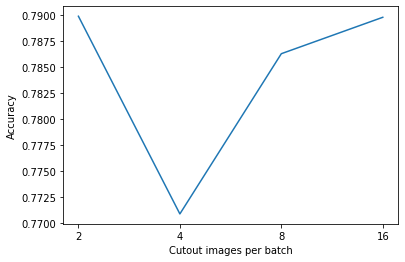

In [5]:
import matplotlib.pyplot as plt

ms=[2,4,8,16]

values = [
    0.789900004863739,
    0.7709000110626221,
    0.786300003528595,
    0.7897999882698059
]


training_times = [
    1500.6697494983673,
    2691.5938482284546,
    4887.652304410934,
    9786.10599064827
]

plt.plot(range(len(values)), values)
plt.xticks(range(len(values)), ms)
plt.ylabel('Accuracy')
plt.xlabel('Cutout images per batch')

plt.savefig('cutout_exp_accuracies.jpg', bbox_inches = 'tight')

plt.show()

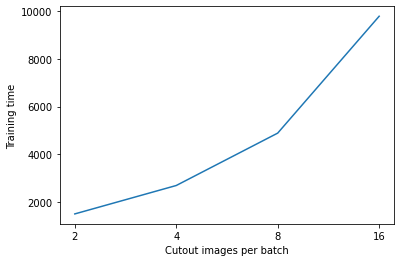

In [7]:
plt.plot(range(len(training_times)), training_times)
plt.xticks(range(len(training_times)), ms)
plt.ylabel('Training time')
plt.xlabel('Cutout images per batch')

plt.savefig('cutout_exp_times.jpg', bbox_inches = 'tight')

plt.show()

In [23]:
dp = 2
prob = 0.2
bn = 2

for m in [2, 16]:
    print('Training BN{}, DPID{}, DPCONV{}, DPPROB{} with cutout regularization augmenting with {} images -- convergence'.format(bn, dp, dp, prob, m))
    model_name = 'model_bn{}_dpid_{}_dpconv_{}_dpprob_{}_cutout{}__convergence'.format(bn, dp, dp, prob, m)
    resnet_model = resnet50(num_batchnorm=bn, bn_pooling=True, num_dropout_conv=dp, num_dropout_id=dp, dropout_prob=prob)
    tt, acc = fit_resnet_dataaug(resnet_model,x_train, y_train, x_test, y_test, model_name, m=m, convergence=True)

    print('Final accuracy {} reached in {}'.format(acc, tt))

Training BN2, DPID2, DPCONV2, DPPROB0.2 with cutout regularization augmenting with 2 images -- convergence
Fitting with BS  256
0 0
end {'loss': 2.0145556926727295, 'accuracy': 0.3443509638309479}
Time to reach 0.87 accuracy: 337.87398171424866 s
25 25
end {'loss': 0.2765456438064575, 'accuracy': 0.900971531867981}
50 50
end {'loss': 0.11017855256795883, 'accuracy': 0.9616686701774597}
75 75
end {'loss': 0.16221535205841064, 'accuracy': 0.944451093673706}
100 100
end {'loss': 0.057838018983602524, 'accuracy': 0.9803485870361328}
125 125
end {'loss': 0.04218747466802597, 'accuracy': 0.9854066371917725}
150 150
end {'loss': 0.03655320778489113, 'accuracy': 0.9875300526618958}
175 175
end {'loss': 0.03279444947838783, 'accuracy': 0.9886217713356018}
200 200
end {'loss': 0.02311616763472557, 'accuracy': 0.9924378991127014}
225 225
end {'loss': 0.02629760093986988, 'accuracy': 0.9911458492279053}
313/313 [==============================] - 4s 9ms/step - loss: 1.4342 - accuracy: 0.7766
Final 

## Non-Uniform Dropout Probability

Testing the effect of varying the dropout probability across layers. 

Batch Size: 256

Number of Dropout Layers: 3

Number of BatchNorm Layers: 2

Dropout Probability: [0.1, 0.2, 0.3]

Data Augmentation: true


In [25]:
#Define the Model
#Removing all regularizers

def res_identity(x, filters, num_batchnorm = 0, num_dropout=0, dropout_prob = [0,0,0]):
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

    x_skip = x # this will be used for addition with the residual block 
    f1, f2 = filters
    bn = num_batchnorm
    drp = num_dropout

    #first block 
    x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
    if bn>0:
        x = BatchNormalization()(x)
        bn-=1
    x = Activation(activations.relu)(x)
    if drp>0:
        x = Dropout(dropout_prob[0])(x)
        drp-=1

    #second block # bottleneck (but size kept same with padding)
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    if bn>0:
        x = BatchNormalization()(x)
        bn-=1
    x = Activation(activations.relu)(x)
    if drp>0:
        x = Dropout(dropout_prob[1])(x)
        drp-=1

    # third block activation used after adding the input
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
    if bn>0:
        x = BatchNormalization()(x)
        bn-=1
    x = Activation(activations.relu)(x)
    if drp>0:
        x = Dropout(dropout_prob[2])(x)
        drp-=1

    # add the input 
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)


    return x

def res_conv(x, s, filters, num_batchnorm = 0, num_dropout=0, dropout_prob = [0,0,0]):
    x_skip = x
    f1, f2 = filters
    bn = num_batchnorm
    drp = num_dropout

    # first block
    x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid')(x)
    # when s = 2 then it is like downsizing the feature map
    if bn>0:
        x = BatchNormalization()(x)
        bn-=1
    x = Activation(activations.relu)(x)
    if drp>0:
        x = Dropout(dropout_prob[0])(x)
        drp-=1

    # second block
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    if bn>0:
        x = BatchNormalization()(x)
        bn-=1
    x = Activation(activations.relu)(x)
    if drp>0:
        x = Dropout(dropout_prob[1])(x)
        drp-=1

    #third block
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
    if bn>0:
        x = BatchNormalization()(x)
        bn-=1

    # shortcut 
    x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid')(x_skip)
    x_skip = BatchNormalization()(x_skip)

    # add 
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)

    return x

def resnet50(num_batchnorm = 0, bn_pooling = False, dropout_prob=[0,0,0], num_dropout_conv = 0, num_dropout_id = 0, num_dropout=0):

    input_im = Input(shape=(32, 32, 3)) # cifar 10 images size
    x = ZeroPadding2D(padding=(3, 3))(input_im)
    bn = num_batchnorm
    drp = num_dropout

    # 1st stage
    # here we perform maxpooling, see the figure above

    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
    if bn_pooling:
        x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    if drp>0:
        x = Dropout(dropout_prob[0])(x)
        drp-=1

    #2nd stage 
    # frm here on only conv block and identity block, no pooling

    x = res_conv(x, s=1, filters=(64, 256),num_batchnorm=bn, num_dropout = num_dropout_conv, dropout_prob = dropout_prob)
    x = res_identity(x, filters=(64, 256),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)
    x = res_identity(x, filters=(64, 256),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)

    # 3rd stage

    x = res_conv(x, s=2, filters=(128, 512),num_batchnorm=bn, num_dropout = num_dropout_conv, dropout_prob = dropout_prob)
    x = res_identity(x, filters=(128, 512),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)
    x = res_identity(x, filters=(128, 512),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)
    x = res_identity(x, filters=(128, 512),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)

    # 4th stage

    x = res_conv(x, s=2, filters=(256, 1024),num_batchnorm=bn, num_dropout = num_dropout_conv, dropout_prob = dropout_prob)
    x = res_identity(x, filters=(256, 1024),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)
    x = res_identity(x, filters=(256, 1024),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)
    x = res_identity(x, filters=(256, 1024),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)
    x = res_identity(x, filters=(256, 1024),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)
    x = res_identity(x, filters=(256, 1024),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)

    # 5th stage

    x = res_conv(x, s=2, filters=(512, 2048),num_batchnorm=bn, num_dropout = num_dropout_conv, dropout_prob = dropout_prob)
    x = res_identity(x, filters=(512, 2048),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)
    x = res_identity(x, filters=(512, 2048),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)

    # ends with average pooling and dense connection

    x = AveragePooling2D((2, 2), padding='same')(x)

    x = Flatten()(x)
    if drp>0:
        x = Dropout(dropout_prob[1])(x)
        drp-=1
    x = Dense(10, activation='softmax')(x) #multi-class

    # define the model 

    model = Model(inputs=input_im, outputs=x, name='Resnet50')

    return model

In [26]:
#to measure Time to Accuracy
#https://keras.io/guides/writing_your_own_callbacks/

class timeToAccuracy(keras.callbacks.Callback):
    def __init__(self, startTime, epoch_ckpt, model_name):
        super(timeToAccuracy, self).__init__()
        self.targetAcc = 0.87 #CHANGE TO 0.87 WHEN RUNNING MODEL
        self.foundTarget = False
        self.startTime = startTime
        self.epoch = 0
        self.epoch_ckpt = epoch_ckpt
        self.model_name = model_name
        self.prev_loss = None
    def on_epoch_end(self, epoch, logs=None):
        if self.epoch % self.epoch_ckpt == 0:
            print(self.epoch, epoch)
            name = self.model_name + '.h5'
            self.model.save_weights(name)
            print('end', logs)
            
        self.epoch += 1
#         if (self.prev_loss == None):
#             self.prev_loss = logs['loss']
#         else:
#             delta = np.abs(logs['loss'] - self.prev_loss)
        if not self.foundTarget:
            if logs['accuracy'] >= self.targetAcc:
                current = time.time()
                print("Time to reach {} accuracy: {} s".format(self.targetAcc, current-self.startTime))
                with open('{}_tta.pkl'.format(model_name), 'wb') as file:
                    pickle.dump(current-self.startTime, file)
                self.foundTarget = True

In [27]:
#prepare data

(x_train, y_train), (x_test, y_test) = cifar10.load_data() 

# Data normalization
x_train = x_train/255
x_test = x_test/255
y_train = to_categorical(y_train) 
y_test = to_categorical(y_test)

In [29]:
def fit_resnet_dataaug(model, xtrain, ytrain, xtest, ytest, model_name, m=0, convergence=False):
  
    EPOCHS = 500 if convergence else 100    
    #EPOCHS=10
    BATCH_SIZE= 256
    VERBOSITY = 0   #Change to 0 when actually running model
    EPOCH_CKPT = 25 # save model every N epochs

    opt = keras.optimizers.Adam(learning_rate=1e-3)

    model.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=['accuracy'])
    #fit the model
    start = time.time()
    print('Fitting with BS ', BATCH_SIZE)
    es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20) if convergence else []
    hist = model.fit_generator(
      batch_generator(
          xtrain,
          ytrain,
          m=m,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, 
          augment=apply_mask
      ),
      epochs=EPOCHS,
      steps_per_epoch=np.floor(xtrain.shape[0]/BATCH_SIZE),
      verbose=VERBOSITY,
      callbacks=[timeToAccuracy(startTime=start, epoch_ckpt=EPOCH_CKPT, model_name=model_name), es]
    )
    train_time = time.time() - start

    #evaluate
    score = model.evaluate(xtest,ytest)
    loss = score[0]
    acc = score[1]

    return train_time,  acc

In [31]:
dp = 3
prob = [0.1,0.2,0.3]
bn = 2
m=2

print('Training BN{}, DPID{}, DPCONV{}, DPPROB{} with cutout regularization augmenting with {} images -- convergence'.format(bn, dp, dp, prob, m))
model_name = 'model_bn{}_dpid_{}_dpconv_{}_dpprob_{}_cutout{}__convergence'.format(bn, dp, dp, prob, m)
resnet_model = resnet50(num_batchnorm=bn, bn_pooling=True, num_dropout_conv=dp, num_dropout_id=dp, dropout_prob=prob)
tt, acc = fit_resnet_dataaug(resnet_model,x_train, y_train, x_test, y_test, model_name, m=m, convergence=True)

print('Final accuracy {} reached in {}'.format(acc, tt))

Training BN2, DPID3, DPCONV3, DPPROB[0.1, 0.2, 0.3] with cutout regularization augmenting with 2 images -- convergence
Fitting with BS  256
0 0
end {'loss': 1.9849753379821777, 'accuracy': 0.34402042627334595}
Time to reach 0.87 accuracy: 353.8247067928314 s
25 25
end {'loss': 0.2959114611148834, 'accuracy': 0.8942908644676208}
50 50
end {'loss': 0.33701395988464355, 'accuracy': 0.885667085647583}
75 75
end {'loss': 0.08119558542966843, 'accuracy': 0.9720953702926636}
100 100
end {'loss': 0.06175059825181961, 'accuracy': 0.9788361191749573}
125 125
end {'loss': 0.04832686856389046, 'accuracy': 0.9833633899688721}
150 150
end {'loss': 0.03850960731506348, 'accuracy': 0.9867788553237915}
175 175
end {'loss': 0.03378571569919586, 'accuracy': 0.9882411956787109}
200 200
end {'loss': 0.027928432449698448, 'accuracy': 0.9903044700622559}
313/313 [==============================] - 4s 10ms/step - loss: 1.3007 - accuracy: 0.7751
Final accuracy 0.7750999927520752 reached in 3290.1112921237946


In [32]:
#Sanity Check on Early Stopping
tt, acc = fit_resnet_dataaug(resnet_model,x_train, y_train, x_test, y_test, model_name, m=m, convergence=True)

print('Final accuracy {} reached in {}'.format(acc, tt))

Fitting with BS  256
0 0
end {'loss': 0.0274589154869318, 'accuracy': 0.990705132484436}
Time to reach 0.87 accuracy: 21.379766941070557 s
25 25
end {'loss': 0.023547060787677765, 'accuracy': 0.9918569922447205}
50 50
end {'loss': 0.020078452304005623, 'accuracy': 0.9932191371917725}
75 75
end {'loss': 0.018917160108685493, 'accuracy': 0.9936298131942749}
100 100
end {'loss': 0.017210695892572403, 'accuracy': 0.9941005706787109}
125 125
end {'loss': 0.016712816432118416, 'accuracy': 0.9943810105323792}
313/313 [==============================] - 4s 9ms/step - loss: 1.4501 - accuracy: 0.7819
Final accuracy 0.7818999886512756 reached in 2109.7273614406586


In [33]:
dp = 3
prob = [0.1,0.2,0.3]
bn = 2
m=8

print('Training BN{}, DPID{}, DPCONV{}, DPPROB{} with cutout regularization augmenting with {} images -- convergence'.format(bn, dp, dp, prob, m))
model_name = 'model_bn{}_dpid_{}_dpconv_{}_dpprob_{}_cutout{}__convergence'.format(bn, dp, dp, prob, m)
resnet_model = resnet50(num_batchnorm=bn, bn_pooling=True, num_dropout_conv=dp, num_dropout_id=dp, dropout_prob=prob)
tt, acc = fit_resnet_dataaug(resnet_model,x_train, y_train, x_test, y_test, model_name, m=m, convergence=True)

print('Final accuracy {} reached in {}'.format(acc, tt))

Training BN2, DPID3, DPCONV3, DPPROB[0.1, 0.2, 0.3] with cutout regularization augmenting with 8 images -- convergence
Fitting with BS  256
0 0
end {'loss': 1.9892884492874146, 'accuracy': 0.34222254157066345}
Time to reach 0.87 accuracy: 706.7439835071564 s
25 25
end {'loss': 0.10552433878183365, 'accuracy': 0.9628405570983887}
50 50
end {'loss': 0.1645677089691162, 'accuracy': 0.9427208304405212}
75 75
end {'loss': 0.028589993715286255, 'accuracy': 0.990349531173706}
100 100
end {'loss': 0.019782431423664093, 'accuracy': 0.9932291507720947}
125 125
end {'loss': 0.01572389528155327, 'accuracy': 0.9947065114974976}
150 150
end {'loss': 0.010338203981518745, 'accuracy': 0.9964869022369385}
175 175
end {'loss': 0.010637978091835976, 'accuracy': 0.9964167475700378}
313/313 [==============================] - 4s 10ms/step - loss: 1.5902 - accuracy: 0.7774
Final accuracy 0.777400016784668 reached in 8916.544905424118


In [ ]:
#Sanity Check on Early Stopping
tt, acc = fit_resnet_dataaug(resnet_model,x_train, y_train, x_test, y_test, model_name, m=m, convergence=True)

print('Final accuracy {} reached in {}'.format(acc, tt))

Fitting with BS  256
0 0
end {'loss': 0.01137738861143589, 'accuracy': 0.9963091015815735}
Time to reach 0.87 accuracy: 55.01160931587219 s
25 25
end {'loss': 0.009120335802435875, 'accuracy': 0.9968299269676208}
313/313 [==============================] - 4s 10ms/step - loss: 1.7476 - accuracy: 0.7665
Final accuracy 0.7664999961853027 reached in 1753.1628396511078
